In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/PMDM
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [3]:
uru.rd_set_image_size(300,300)

### Reading the data from PMDM

Read the smi data to list and check if they are valid molecules or not

In [4]:
smi_list = []
with open('PMDM_1000_control.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in smi_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

len(standardized_smiles_list)

[19:26:17] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:26:17] Explicit valence for atom # 18 C, 5, is greater than permitted
[19:26:17] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:26:17] Explicit valence for atom # 16 C, 5, is greater than permitted
[19:26:17] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:26:17] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:26:17] Explicit valence for atom # 16 N, 4, is greater than permitted
[19:26:17] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:26:17] Explicit valence for atom # 20 C, 5, is greater than permitted
[19:26:17] Explicit valence for atom # 17 C, 5, is greater than permitted
[19:26:17] Explicit valence for atom # 10 N, 4, is greater than permitted


989

Read the smi file generate from PMDM: 10 molecules for receptors in each test set/

In [5]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,CCC(O)C1CC(C2=C(O)CC(O)=C(F)C=C2)c2ccccc21
1,C[P@](=O)(O)C1C[C@@]2(C=NC(=O)CC2O)OC1=N
2,O=C1C2=C(O)C(O)C=C(O)C=C2c2cc3c(c(C(O)(O)O)c21...
3,NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21
4,O=C1CC2CCC1CC1C[C@@](O)(CC3=CCC=CC=C3)c3ccccc3...
...,...
984,O=C1C2c3cc(O)c(O)cc3NCC2[C@@]23CC=CC(CC12)N3
985,OC1=CC=C2C3=C(C=CC=CC13)NC1C(C3=CC=CC=CC3)C(O)...
986,O=C(O)[C@@]1(C2=CC=CC(O)=CC2)CCC2CC1Nc1ccccc12
987,C[C@]12NC=C(O)C(C(=O)O)C1CC1=CC=CC=CC1C2=O


Add an RDKit molecule to the dataframe

In [6]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)
df

,SMILES,mol
0,CCC(O)C1CC(C2=C(O)CC(O)=C(F)C=C2)c2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae637d8c0>
1,C[P@](=O)(O)C1C[C@@]2(C=NC(=O)CC2O)OC1=N,<rdkit.Chem.rdchem.Mol object at 0x7f6ae637d930>
2,O=C1C2=C(O)C(O)C=C(O)C=C2c2cc3c(c(C(O)(O)O)c21...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae637d5b0>
3,NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae637d620>
4,O=C1CC2CCC1CC1C[C@@](O)(CC3=CCC=CC=C3)c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae637d3f0>
...,...,...
984,O=C1C2c3cc(O)c(O)cc3NCC2[C@@]23CC=CC(CC12)N3,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4820>
985,OC1=CC=C2C3=C(C=CC=CC13)NC1C(C3=CC=CC=CC3)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4890>
986,O=C(O)[C@@]1(C2=CC=CC(O)=CC2)CCC2CC1Nc1ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4900>
987,C[C@]12NC=C(O)C(C(=O)O)C1CC1=CC=CC=CC1C2=O,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4970>


Strip salts from the molecule

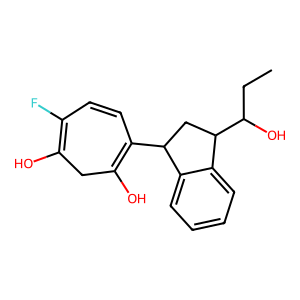

In [7]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [8]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0                        [c1ccc2c(c1)CCC2, C1=CC=CCC=C1]
1                          [N=C1CC[C@@]2(C=NC(=O)CC2)O1]
2            [O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13]
3                      [c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3]
4           [O=C1CC2CCC1CC1CCc3ccccc3C1N2, C1=CC=CCC=C1]
                             ...                        
984             [O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3]
985    [C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2, C1=CC...
986                [c1ccc2c(c1)NC1CCCC2C1, C1=CC=CCC=C1]
987                    [O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12]
988              [O=C1CCN2CC=C3CNC1C32, c1ccc2c(c1)CCC2]
Name: ring_sytems, Length: 989, dtype: object

In [9]:
df.ring_sytems.values

array([list(['c1ccc2c(c1)CCC2', 'C1=CC=CCC=C1']),
       list(['N=C1CC[C@@]2(C=NC(=O)CC2)O1']),
       list(['O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13']),
       list(['c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3']),
       list(['O=C1CC2CCC1CC1CCc3ccccc3C1N2', 'C1=CC=CCC=C1']),
       list(['O=C1C=CC2C(=N1)CC=CC1C=C3C=CCCOC3C12']),
       list(['O=c1c2ccccc2n2n1C1=CN=COC1CC2', 'O=C1CCCN1']),
       list(['O=C1C=C2NCC3CCCOC3C2CN1', 'C1=CC=CCC=C1']),
       list(['C1CCCC1']), list(['c1ccccc1']),
       list(['C=C1C(=O)Cc2ccc3c(c2NC(=O)CCCc2ccc4c(c2)C1CN4)CCC3']),
       list(['C1=CCNC=C1', 'c1ccccc1', 'C1=CC=CCC=C1']),
       list(['C1=C2CCCC2=CCC1']), list(['c1ccccc1']),
       list(['C1=CCN2CCC3CCC[C@H]3C2=C1']),
       list(['C1CCC2CC(C1)C[C@]13CC4CCC[C@@]1(CCC23)C4']),
       list(['c1ccccc1', 'c1ccc2c(c1)CCO2']),
       list(['C1=CC2CCC[C@@H]2CC1', 'C1=CC=CCC=C1', 'c1ccc2c(c1)CCCO2']),
       list(['c1ccccc1', 'c1cncnc1', 'c1cncnc1', 'O=C1CCC=CN1']),
       list(['O=C1CC(=O)/C2=C/CCNCCC2N1', 

See how many times each ring system occurs

In [10]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
11,c1ccccc1,282
1,C1=CC=CCC=C1,138
10,C1CCCC1,57
24,c1ccncc1,41
0,c1ccc2c(c1)CCC2,21
...,...,...
318,C1=NCc2cc3c(c4ccnc1c24)-c1ccccc1C3,1
319,O=C1NCC2=C1CCC2,1
320,O=C1C=CCCO1,1
321,C1CNC2[C@H]3OCC[C@H]3N2C1,1


View the ring system frequencies

In [11]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [12]:
ring_system_lookup = uru.RingSystemLookup.default()
res = df.mol.apply(ring_system_lookup.process_mol)

In [13]:
res

0           [(c1ccc2c(c1)CCC2, 8662), (C1=CC=CCC=C1, 8)]
1                     [(N=C1CC[C@@]2(C=NC(=O)CC2)O1, 0)]
2       [(O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13, 0)]
3                 [(c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3, 0)]
4      [(O=C1CC2CCC1CC1CCc3ccccc3C1N2, 0), (C1=CC=CCC...
                             ...                        
984        [(O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3, 0)]
985    [(C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2, 0), ...
986      [(c1ccc2c(c1)NC1CCCC2C1, 0), (C1=CC=CCC=C1, 8)]
987               [(O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12, 0)]
988    [(O=C1CCN2CC=C3CNC1C32, 0), (c1ccc2c(c1)CCC2, ...
Name: mol, Length: 989, dtype: object

In [14]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,CCC(O)C1CC(C2=C(O)CC(O)=C(F)C=C2)c2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a52a0>,"[c1ccc2c(c1)CCC2, C1=CC=CCC=C1]",C1=CC=CCC=C1,8
1,C[P@](=O)(O)C1C[C@@]2(C=NC(=O)CC2O)OC1=N,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5930>,[N=C1CC[C@@]2(C=NC(=O)CC2)O1],N=C1CC[C@@]2(C=NC(=O)CC2)O1,0
2,O=C1C2=C(O)C(O)C=C(O)C=C2c2cc3c(c(C(O)(O)O)c21...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a54d0>,[O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13],O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13,0
3,NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5380>,[c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3],c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3,0
4,O=C1CC2CCC1CC1C[C@@](O)(CC3=CCC=CC=C3)c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4c80>,"[O=C1CC2CCC1CC1CCc3ccccc3C1N2, C1=CC=CCC=C1]",O=C1CC2CCC1CC1CCc3ccccc3C1N2,0
...,...,...,...,...,...
984,O=C1C2c3cc(O)c(O)cc3NCC2[C@@]23CC=CC(CC12)N3,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3d80>,[O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3],O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3,0
985,OC1=CC=C2C3=C(C=CC=CC13)NC1C(C3=CC=CC=CC3)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3df0>,"[C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2, C1=CC...",C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2,0
986,O=C(O)[C@@]1(C2=CC=CC(O)=CC2)CCC2CC1Nc1ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3e60>,"[c1ccc2c(c1)NC1CCCC2C1, C1=CC=CCC=C1]",c1ccc2c(c1)NC1CCCC2C1,0
987,C[C@]12NC=C(O)C(C(=O)O)C1CC1=CC=CC=CC1C2=O,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3ed0>,[O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12],O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12,0


In [15]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [16]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefined stereo

[19:26:19] WARNING: Omitted undefi

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CCC(O)C1CC(C2=C(O)CC(O)=C(F)C=C2)c2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a52a0>,"[c1ccc2c(c1)CCC2, C1=CC=CCC=C1]",C1=CC=CCC=C1,8,InChI=1S/C19H21FO3/c1-2-17(21)15-9-14(11-5-3-4...
1,C[P@](=O)(O)C1C[C@@]2(C=NC(=O)CC2O)OC1=N,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5930>,[N=C1CC[C@@]2(C=NC(=O)CC2)O1],N=C1CC[C@@]2(C=NC(=O)CC2)O1,0,"InChI=1S/C9H13N2O5P/c1-17(14,15)5-3-9(16-8(5)1..."
2,O=C1C2=C(O)C(O)C=C(O)C=C2c2cc3c(c(C(O)(O)O)c21...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a54d0>,[O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13],O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13,0,InChI=1S/C20H14N2O8/c23-6-1-8-9-4-10-11-2-7(24...
3,NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5380>,[c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3],c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3,0,InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...
4,O=C1CC2CCC1CC1C[C@@](O)(CC3=CCC=CC=C3)c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4c80>,"[O=C1CC2CCC1CC1CCc3ccccc3C1N2, C1=CC=CCC=C1]",O=C1CC2CCC1CC1CCc3ccccc3C1N2,0,InChI=1S/C25H29NO2/c27-23-14-20-12-11-18(23)13...
...,...,...,...,...,...,...
977,O=C1C2c3cc(O)c(O)cc3NCC2[C@@]23CC=CC(CC12)N3,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3d80>,[O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3],O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3,0,InChI=1S/C17H18N2O3/c20-13-5-9-12(6-14(13)21)1...
978,OC1=CC=C2C3=C(C=CC=CC13)NC1C(C3=CC=CC=CC3)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3df0>,"[C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2, C1=CC...",C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2,0,InChI=1S/C24H25NO5/c26-17-12-11-15-19-14(17)9-...
979,O=C(O)[C@@]1(C2=CC=CC(O)=CC2)CCC2CC1Nc1ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3e60>,"[c1ccc2c(c1)NC1CCCC2C1, C1=CC=CCC=C1]",c1ccc2c(c1)NC1CCCC2C1,0,InChI=1S/C20H21NO3/c22-15-5-3-4-14(8-9-15)20(1...
980,C[C@]12NC=C(O)C(C(=O)O)C1CC1=CC=CC=CC1C2=O,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3ed0>,[O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12],O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12,0,InChI=1S/C16H17NO4/c1-16-11(13(15(20)21)12(18)...


How many molecules have ring system?

In [17]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CCC(O)C1CC(C2=C(O)CC(O)=C(F)C=C2)c2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a52a0>,"[c1ccc2c(c1)CCC2, C1=CC=CCC=C1]",C1=CC=CCC=C1,8,InChI=1S/C19H21FO3/c1-2-17(21)15-9-14(11-5-3-4...
1,C[P@](=O)(O)C1C[C@@]2(C=NC(=O)CC2O)OC1=N,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5930>,[N=C1CC[C@@]2(C=NC(=O)CC2)O1],N=C1CC[C@@]2(C=NC(=O)CC2)O1,0,"InChI=1S/C9H13N2O5P/c1-17(14,15)5-3-9(16-8(5)1..."
2,O=C1C2=C(O)C(O)C=C(O)C=C2c2cc3c(c(C(O)(O)O)c21...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a54d0>,[O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13],O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13,0,InChI=1S/C20H14N2O8/c23-6-1-8-9-4-10-11-2-7(24...
3,NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5380>,[c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3],c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3,0,InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...
4,O=C1CC2CCC1CC1C[C@@](O)(CC3=CCC=CC=C3)c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4c80>,"[O=C1CC2CCC1CC1CCc3ccccc3C1N2, C1=CC=CCC=C1]",O=C1CC2CCC1CC1CCc3ccccc3C1N2,0,InChI=1S/C25H29NO2/c27-23-14-20-12-11-18(23)13...
...,...,...,...,...,...,...
977,O=C1C2c3cc(O)c(O)cc3NCC2[C@@]23CC=CC(CC12)N3,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3d80>,[O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3],O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3,0,InChI=1S/C17H18N2O3/c20-13-5-9-12(6-14(13)21)1...
978,OC1=CC=C2C3=C(C=CC=CC13)NC1C(C3=CC=CC=CC3)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3df0>,"[C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2, C1=CC...",C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2,0,InChI=1S/C24H25NO5/c26-17-12-11-15-19-14(17)9-...
979,O=C(O)[C@@]1(C2=CC=CC(O)=CC2)CCC2CC1Nc1ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3e60>,"[c1ccc2c(c1)NC1CCCC2C1, C1=CC=CCC=C1]",c1ccc2c(c1)NC1CCCC2C1,0,InChI=1S/C20H21NO3/c22-15-5-3-4-14(8-9-15)20(1...
980,C[C@]12NC=C(O)C(C(=O)O)C1CC1=CC=CC=CC1C2=O,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3ed0>,[O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12],O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12,0,InChI=1S/C16H17NO4/c1-16-11(13(15(20)21)12(18)...


In [18]:
filtered_df_ring_freq = df[df.min_freq > 100]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
8,OC1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5070>,[C1CCCC1],C1CCCC1,30433,"InChI=1S/C5H10O/c6-5-3-1-2-4-5/h5-6H,1-4H2"
9,CC(=O)c1ccc(N)c(C(=O)O)c1,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a50e0>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C9H9NO3/c1-5(11)6-2-3-8(10)7(4-6)9(12...
13,NC(=O)c1cccc(Cl)c1,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5230>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C7H6ClNO/c8-6-3-1-2-5(4-6)7(9)10/h1-4...
16,O=C(O)C(=O)c1ccccc1-c1ccc2c(c1)OC(CO)C2,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4cf0>,"[c1ccccc1, c1ccc2c(c1)CCO2]",c1ccc2c(c1)CCO2,3858,InChI=1S/C17H14O5/c18-9-12-7-11-6-5-10(8-15(11...
18,Cc1ccc(CCc2cnc(N(c3ncccn3)C3C=CNC(=O)C3)nc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4b30>,"[c1ccccc1, c1cncnc1, c1cncnc1, O=C1CCC=CN1]",O=C1CCC=CN1,598,InChI=1S/C22H22N6O/c1-16-3-5-17(6-4-16)7-8-18-...
...,...,...,...,...,...,...
934,CC1C[C@]2(C)CC(C[C@]3(O)NC(=O)c4ccccc4NC3=O)C1C2,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c2ab0>,"[C1CC2CCC1C2, O=C1CNC(=O)c2ccccc2N1]",C1CC2CCC1C2,198,InChI=1S/C19H24N2O3/c1-11-7-18(2)8-12(14(11)10...
942,O=C1NC=C(O)C(O)C1O,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c2e30>,[O=C1CCC=CN1],O=C1CCC=CN1,598,"InChI=1S/C5H7NO4/c7-2-1-6-5(10)4(9)3(2)8/h1,3-..."
949,CC(=O)CCCC1CCC(O)C1,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3140>,[C1CCCC1],C1CCCC1,30433,InChI=1S/C10H18O2/c1-8(11)3-2-4-9-5-6-10(12)7-...
962,NC1CC(=O)N(O)C(=O)C1N,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c36f0>,[O=C1CCCC(=O)N1],O=C1CCCC(=O)N1,2112,InChI=1S/C5H9N3O3/c6-2-1-3(9)8(11)5(10)4(2)7/h...


### How many of them could pass PAINS filter?

Get a list of rules

In [19]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [20]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [21]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [22]:
reos.pandas_mols(df.mol)

  0%|          | 0/982 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,PAINS,mannich_A(296)
4,ok,ok
...,...,...
977,PAINS,catechol_A(92)
978,ok,ok
979,ok,ok
980,ok,ok


In [23]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/982 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,CCC(O)C1CC(C2=C(O)CC(O)=C(F)C=C2)c2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a52a0>,"[c1ccc2c(c1)CCC2, C1=CC=CCC=C1]",C1=CC=CCC=C1,8,InChI=1S/C19H21FO3/c1-2-17(21)15-9-14(11-5-3-4...,ok,ok
1,C[P@](=O)(O)C1C[C@@]2(C=NC(=O)CC2O)OC1=N,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5930>,[N=C1CC[C@@]2(C=NC(=O)CC2)O1],N=C1CC[C@@]2(C=NC(=O)CC2)O1,0,"InChI=1S/C9H13N2O5P/c1-17(14,15)5-3-9(16-8(5)1...",ok,ok
2,O=C1C2=C(O)C(O)C=C(O)C=C2c2cc3c(c(C(O)(O)O)c21...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a54d0>,[O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13],O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13,0,InChI=1S/C20H14N2O8/c23-6-1-8-9-4-10-11-2-7(24...,ok,ok
4,O=C1CC2CCC1CC1C[C@@](O)(CC3=CCC=CC=C3)c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4c80>,"[O=C1CC2CCC1CC1CCc3ccccc3C1N2, C1=CC=CCC=C1]",O=C1CC2CCC1CC1CCc3ccccc3C1N2,0,InChI=1S/C25H29NO2/c27-23-14-20-12-11-18(23)13...,ok,ok
5,O=C1C=CC2C(=N1)CC=CC1C=C3C(O)=CCCOC3C12,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4ac0>,[O=C1C=CC2C(=N1)CC=CC1C=C3C=CCCOC3C12],O=C1C=CC2C(=N1)CC=CC1C=C3C=CCCOC3C12,0,InChI=1S/C17H17NO3/c19-14-5-2-8-21-17-12(14)9-...,ok,ok
...,...,...,...,...,...,...,...,...
976,N=C1C2=C(C=CC=CC2)CC2C3=CC=CCC(O)=C3C(=O)N12,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3d10>,[N=C1C2=C(C=CC=CC2)CC2C3=CC=CCC=C3C(=O)N12],N=C1C2=C(C=CC=CC2)CC2C3=CC=CCC=C3C(=O)N12,0,InChI=1S/C18H16N2O2/c19-17-12-7-3-1-2-6-11(12)...,ok,ok
978,OC1=CC=C2C3=C(C=CC=CC13)NC1C(C3=CC=CC=CC3)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3df0>,"[C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2, C1=CC...",C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2,0,InChI=1S/C24H25NO5/c26-17-12-11-15-19-14(17)9-...,ok,ok
979,O=C(O)[C@@]1(C2=CC=CC(O)=CC2)CCC2CC1Nc1ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3e60>,"[c1ccc2c(c1)NC1CCCC2C1, C1=CC=CCC=C1]",c1ccc2c(c1)NC1CCCC2C1,0,InChI=1S/C20H21NO3/c22-15-5-3-4-14(8-9-15)20(1...,ok,ok
980,C[C@]12NC=C(O)C(C(=O)O)C1CC1=CC=CC=CC1C2=O,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3ed0>,[O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12],O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12,0,InChI=1S/C16H17NO4/c1-16-11(13(15(20)21)12(18)...,ok,ok


### How many of them could pass filters suggested by Dr.Reymond?

In [24]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CCC(O)C1CC(C2=C(O)CC(O)=C(F)C=C2)c2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a52a0>,"[c1ccc2c(c1)CCC2, C1=CC=CCC=C1]",C1=CC=CCC=C1,8,InChI=1S/C19H21FO3/c1-2-17(21)15-9-14(11-5-3-4...,True
1,C[P@](=O)(O)C1C[C@@]2(C=NC(=O)CC2O)OC1=N,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5930>,[N=C1CC[C@@]2(C=NC(=O)CC2)O1],N=C1CC[C@@]2(C=NC(=O)CC2)O1,0,"InChI=1S/C9H13N2O5P/c1-17(14,15)5-3-9(16-8(5)1...",True
2,O=C1C2=C(O)C(O)C=C(O)C=C2c2cc3c(c(C(O)(O)O)c21...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a54d0>,[O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13],O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13,0,InChI=1S/C20H14N2O8/c23-6-1-8-9-4-10-11-2-7(24...,True
3,NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5380>,[c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3],c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3,0,InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...,True
4,O=C1CC2CCC1CC1C[C@@](O)(CC3=CCC=CC=C3)c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4c80>,"[O=C1CC2CCC1CC1CCc3ccccc3C1N2, C1=CC=CCC=C1]",O=C1CC2CCC1CC1CCc3ccccc3C1N2,0,InChI=1S/C25H29NO2/c27-23-14-20-12-11-18(23)13...,True
...,...,...,...,...,...,...,...
977,O=C1C2c3cc(O)c(O)cc3NCC2[C@@]23CC=CC(CC12)N3,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3d80>,[O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3],O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3,0,InChI=1S/C17H18N2O3/c20-13-5-9-12(6-14(13)21)1...,True
978,OC1=CC=C2C3=C(C=CC=CC13)NC1C(C3=CC=CC=CC3)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3df0>,"[C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2, C1=CC...",C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2,0,InChI=1S/C24H25NO5/c26-17-12-11-15-19-14(17)9-...,True
979,O=C(O)[C@@]1(C2=CC=CC(O)=CC2)CCC2CC1Nc1ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3e60>,"[c1ccc2c(c1)NC1CCCC2C1, C1=CC=CCC=C1]",c1ccc2c(c1)NC1CCCC2C1,0,InChI=1S/C20H21NO3/c22-15-5-3-4-14(8-9-15)20(1...,True
980,C[C@]12NC=C(O)C(C(=O)O)C1CC1=CC=CC=CC1C2=O,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3ed0>,[O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12],O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12,0,InChI=1S/C16H17NO4/c1-16-11(13(15(20)21)12(18)...,True


In [25]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CCC(O)C1CC(C2=C(O)CC(O)=C(F)C=C2)c2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a52a0>,"[c1ccc2c(c1)CCC2, C1=CC=CCC=C1]",C1=CC=CCC=C1,8,InChI=1S/C19H21FO3/c1-2-17(21)15-9-14(11-5-3-4...,True
1,C[P@](=O)(O)C1C[C@@]2(C=NC(=O)CC2O)OC1=N,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5930>,[N=C1CC[C@@]2(C=NC(=O)CC2)O1],N=C1CC[C@@]2(C=NC(=O)CC2)O1,0,"InChI=1S/C9H13N2O5P/c1-17(14,15)5-3-9(16-8(5)1...",True
2,O=C1C2=C(O)C(O)C=C(O)C=C2c2cc3c(c(C(O)(O)O)c21...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a54d0>,[O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13],O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13,0,InChI=1S/C20H14N2O8/c23-6-1-8-9-4-10-11-2-7(24...,True
3,NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5380>,[c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3],c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3,0,InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...,True
4,O=C1CC2CCC1CC1C[C@@](O)(CC3=CCC=CC=C3)c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4c80>,"[O=C1CC2CCC1CC1CCc3ccccc3C1N2, C1=CC=CCC=C1]",O=C1CC2CCC1CC1CCc3ccccc3C1N2,0,InChI=1S/C25H29NO2/c27-23-14-20-12-11-18(23)13...,True
...,...,...,...,...,...,...,...
977,O=C1C2c3cc(O)c(O)cc3NCC2[C@@]23CC=CC(CC12)N3,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3d80>,[O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3],O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3,0,InChI=1S/C17H18N2O3/c20-13-5-9-12(6-14(13)21)1...,True
978,OC1=CC=C2C3=C(C=CC=CC13)NC1C(C3=CC=CC=CC3)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3df0>,"[C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2, C1=CC...",C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2,0,InChI=1S/C24H25NO5/c26-17-12-11-15-19-14(17)9-...,True
979,O=C(O)[C@@]1(C2=CC=CC(O)=CC2)CCC2CC1Nc1ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3e60>,"[c1ccc2c(c1)NC1CCCC2C1, C1=CC=CCC=C1]",c1ccc2c(c1)NC1CCCC2C1,0,InChI=1S/C20H21NO3/c22-15-5-3-4-14(8-9-15)20(1...,True
980,C[C@]12NC=C(O)C(C(=O)O)C1CC1=CC=CC=CC1C2=O,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3ed0>,[O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12],O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12,0,InChI=1S/C16H17NO4/c1-16-11(13(15(20)21)12(18)...,True


### How many of them could pass RO5?

In [26]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCC(O)C1CC(C2=C(O)CC(O)=C(F)C=C2)c2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a52a0>,"[c1ccc2c(c1)CCC2, C1=CC=CCC=C1]",C1=CC=CCC=C1,8,InChI=1S/C19H21FO3/c1-2-17(21)15-9-14(11-5-3-4...,True,True
1,C[P@](=O)(O)C1C[C@@]2(C=NC(=O)CC2O)OC1=N,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5930>,[N=C1CC[C@@]2(C=NC(=O)CC2)O1],N=C1CC[C@@]2(C=NC(=O)CC2)O1,0,"InChI=1S/C9H13N2O5P/c1-17(14,15)5-3-9(16-8(5)1...",True,True
2,O=C1C2=C(O)C(O)C=C(O)C=C2c2cc3c(c(C(O)(O)O)c21...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a54d0>,[O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13],O=C1C2=CCC=CC=C2c2cc3c(cc21)N=C1N=CCC=C13,0,InChI=1S/C20H14N2O8/c23-6-1-8-9-4-10-11-2-7(24...,True,False
3,NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5380>,[c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3],c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3,0,InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...,True,True
4,O=C1CC2CCC1CC1C[C@@](O)(CC3=CCC=CC=C3)c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4c80>,"[O=C1CC2CCC1CC1CCc3ccccc3C1N2, C1=CC=CCC=C1]",O=C1CC2CCC1CC1CCc3ccccc3C1N2,0,InChI=1S/C25H29NO2/c27-23-14-20-12-11-18(23)13...,True,True
...,...,...,...,...,...,...,...,...
977,O=C1C2c3cc(O)c(O)cc3NCC2[C@@]23CC=CC(CC12)N3,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3d80>,[O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3],O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3,0,InChI=1S/C17H18N2O3/c20-13-5-9-12(6-14(13)21)1...,True,True
978,OC1=CC=C2C3=C(C=CC=CC13)NC1C(C3=CC=CC=CC3)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3df0>,"[C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2, C1=CC...",C1=CC2=C3C(=CC=CC3C=C1)C[C@@H]1CCCC1N2,0,InChI=1S/C24H25NO5/c26-17-12-11-15-19-14(17)9-...,True,False
979,O=C(O)[C@@]1(C2=CC=CC(O)=CC2)CCC2CC1Nc1ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3e60>,"[c1ccc2c(c1)NC1CCCC2C1, C1=CC=CCC=C1]",c1ccc2c(c1)NC1CCCC2C1,0,InChI=1S/C20H21NO3/c22-15-5-3-4-14(8-9-15)20(1...,True,True
980,C[C@]12NC=C(O)C(C(=O)O)C1CC1=CC=CC=CC1C2=O,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3ed0>,[O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12],O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12,0,InChI=1S/C16H17NO4/c1-16-11(13(15(20)21)12(18)...,True,True


In [27]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCC(O)C1CC(C2=C(O)CC(O)=C(F)C=C2)c2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a52a0>,"[c1ccc2c(c1)CCC2, C1=CC=CCC=C1]",C1=CC=CCC=C1,8,InChI=1S/C19H21FO3/c1-2-17(21)15-9-14(11-5-3-4...,True,True
1,C[P@](=O)(O)C1C[C@@]2(C=NC(=O)CC2O)OC1=N,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5930>,[N=C1CC[C@@]2(C=NC(=O)CC2)O1],N=C1CC[C@@]2(C=NC(=O)CC2)O1,0,"InChI=1S/C9H13N2O5P/c1-17(14,15)5-3-9(16-8(5)1...",True,True
3,NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a5380>,[c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3],c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3,0,InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...,True,True
4,O=C1CC2CCC1CC1C[C@@](O)(CC3=CCC=CC=C3)c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4c80>,"[O=C1CC2CCC1CC1CCc3ccccc3C1N2, C1=CC=CCC=C1]",O=C1CC2CCC1CC1CCc3ccccc3C1N2,0,InChI=1S/C25H29NO2/c27-23-14-20-12-11-18(23)13...,True,True
5,O=C1C=CC2C(=N1)CC=CC1C=C3C(O)=CCCOC3C12,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63a4ac0>,[O=C1C=CC2C(=N1)CC=CC1C=C3C=CCCOC3C12],O=C1C=CC2C(=N1)CC=CC1C=C3C=CCCOC3C12,0,InChI=1S/C17H17NO3/c19-14-5-2-8-21-17-12(14)9-...,True,True
...,...,...,...,...,...,...,...,...
976,N=C1C2=C(C=CC=CC2)CC2C3=CC=CCC(O)=C3C(=O)N12,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3d10>,[N=C1C2=C(C=CC=CC2)CC2C3=CC=CCC=C3C(=O)N12],N=C1C2=C(C=CC=CC2)CC2C3=CC=CCC=C3C(=O)N12,0,InChI=1S/C18H16N2O2/c19-17-12-7-3-1-2-6-11(12)...,True,True
977,O=C1C2c3cc(O)c(O)cc3NCC2[C@@]23CC=CC(CC12)N3,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3d80>,[O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3],O=C1C2c3ccccc3NCC2[C@@]23CC=CC(CC12)N3,0,InChI=1S/C17H18N2O3/c20-13-5-9-12(6-14(13)21)1...,True,True
979,O=C(O)[C@@]1(C2=CC=CC(O)=CC2)CCC2CC1Nc1ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3e60>,"[c1ccc2c(c1)NC1CCCC2C1, C1=CC=CCC=C1]",c1ccc2c(c1)NC1CCCC2C1,0,InChI=1S/C20H21NO3/c22-15-5-3-4-14(8-9-15)20(1...,True,True
980,C[C@]12NC=C(O)C(C(=O)O)C1CC1=CC=CC=CC1C2=O,<rdkit.Chem.rdchem.Mol object at 0x7f6ae63c3ed0>,[O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12],O=C1C2C=CC=CC=C2CC2CC=CN[C@H]12,0,InChI=1S/C16H17NO4/c1-16-11(13(15(20)21)12(18)...,True,True


### Check the properties of generated compounds

The aim is to see if we could find specific charateristics of each algorithm

Calculate the molecular weight and then visualize the distribution:

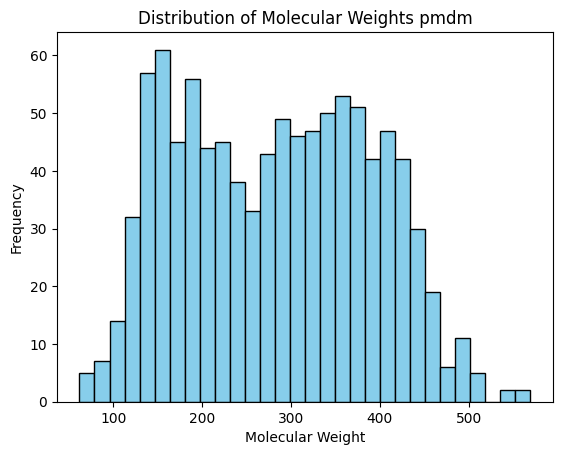

In [35]:
def calculate_molecular_weights(smiles_list):
    """Calculate molecular weights for a list of SMILES strings."""
    molecular_weights = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mw = Descriptors.MolWt(mol)
            molecular_weights.append(mw)
    return molecular_weights

def plot_molecular_weight_distribution(molecular_weights, bins=30):
    """Plot the distribution of molecular weights as a histogram."""
    plt.hist(molecular_weights, bins=bins, color='skyblue', edgecolor='black')
    plt.title("Distribution of Molecular Weights pmdm")
    plt.xlabel("Molecular Weight")
    plt.ylabel("Frequency")
    plt.show()
    
molecular_weights = calculate_molecular_weights(df.SMILES.tolist())
plot_molecular_weight_distribution(molecular_weights)


Number of heavy atoms:

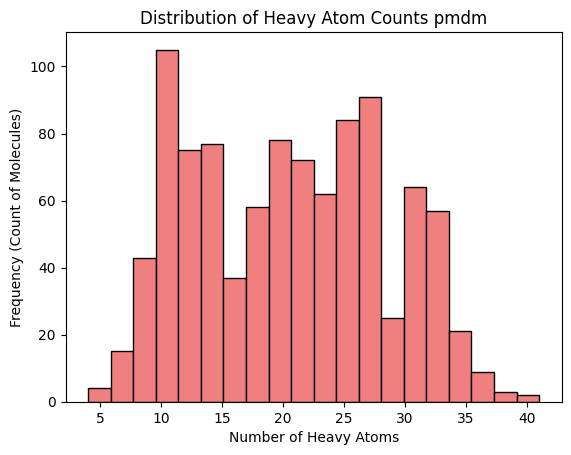

In [34]:
def calculate_heavy_atom_counts(smiles_list):
    """Calculate heavy atom counts for a list of SMILES strings."""
    heavy_atom_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            heavy_atom_count = mol.GetNumHeavyAtoms()
            heavy_atom_counts.append(heavy_atom_count)
    return heavy_atom_counts

def plot_heavy_atom_distribution(heavy_atom_counts, bins=20):
    """Plot the distribution of heavy atom counts as a histogram with frequency on the y-axis."""
    plt.hist(heavy_atom_counts, bins=bins, color='lightcoral', edgecolor='black', density=False)
    plt.title("Distribution of Heavy Atom Counts pmdm")
    plt.xlabel("Number of Heavy Atoms")
    plt.ylabel("Frequency (Count of Molecules)")
    plt.show()
    
heavy_atom_counts = calculate_heavy_atom_counts(df.SMILES.tolist())
plot_heavy_atom_distribution(heavy_atom_counts)

Number of hetero atoms:

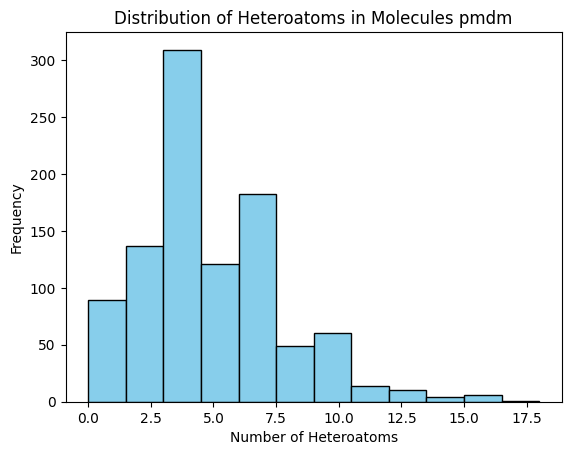

In [33]:
def calculate_heteroatom_counts(smiles_list):
    """Calculate the number of heteroatoms for each SMILES string in the list."""
    heteroatom_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Count atoms that are not C or H
            heteroatom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() not in {1, 6})
            heteroatom_counts.append(heteroatom_count)
    return heteroatom_counts

def plot_heteroatom_distribution(heteroatom_counts, bins=12):
    """Plot the distribution of heteroatom counts as a histogram with frequency on the y-axis."""
    plt.hist(heteroatom_counts, bins=bins, color='skyblue', edgecolor='black', density=False)
    plt.xlabel("Number of Heteroatoms")
    plt.ylabel("Frequency")
    plt.title("Distribution of Heteroatoms in Molecules pmdm")
    plt.show()

heteroatom_counts = calculate_heteroatom_counts(df.SMILES.tolist())
plot_heteroatom_distribution(heteroatom_counts)

Ratio of hetero atoms over heavy atoms:

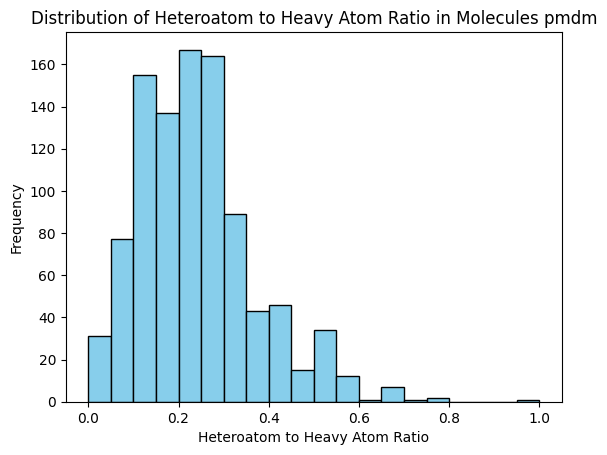

In [32]:
def calculate_heteroatom_ratio(smiles_list):
    """Calculate the ratio of heteroatoms to heavy atoms for each molecule in the SMILES list."""
    heteroatom_ratios = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Count heavy atoms (all atoms except hydrogen)
            heavy_atom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() != 1)
            # Count heteroatoms (atoms other than C and H)
            heteroatom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() not in {1, 6})
            # Calculate ratio if heavy_atom_count is non-zero
            if heavy_atom_count > 0:
                ratio = heteroatom_count / heavy_atom_count
                heteroatom_ratios.append(ratio)
    return heteroatom_ratios

def plot_heteroatom_ratio_distribution(heteroatom_ratios, bins=20):
    """Plot the distribution of heteroatom-to-heavy atom ratios as a histogram with frequency on the y-axis."""
    plt.hist(heteroatom_ratios, bins=bins, color='skyblue', edgecolor='black', density=False)
    plt.xlabel("Heteroatom to Heavy Atom Ratio")
    plt.ylabel("Frequency")
    plt.title("Distribution of Heteroatom to Heavy Atom Ratio in Molecules pmdm")
    plt.show()
    
heteroatom_ratios = calculate_heteroatom_ratio(df.SMILES.tolist())
plot_heteroatom_ratio_distribution(heteroatom_ratios)